In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from timeit import default_timer as timer
#from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier 
#from sklearn.OneVsAllClassifier

import xgboost as xgb

In [351]:
# load data:
fname = 'data/acled_social_iso3_timelag_labeled.csv'
df = pd.read_csv(fname, index_col=0)

In [352]:
df.head()

,EVENT_DATE_MONTH,COUNTRY,Battles,Explosions/Remote violence,Protests,Riots,Strategic developments,Violence against civilians,FATALITIES,YEAR,...,FATALITIES_4_month_ago,Battles_5_month_ago,Protests_5_month_ago,Explosions/Remote violence_5_month_ago,Strategic developments_5_month_ago,Violence against civilians_5_month_ago,FATALITIES_5_month_ago,new_crisis_def,battle_case,protest_riots_case
0,1997-07,Algeria,0.0,1.0,0.0,0.0,0.0,16.0,374.0,1997.0,...,145.0,0.0,0.0,11.0,0.0,23.0,465.0,1.0,0.0,0.0
1,1997-08,Algeria,1.0,1.0,0.0,0.0,0.0,13.0,665.0,1997.0,...,415.0,0.0,0.0,0.0,0.0,8.0,145.0,1.0,0.0,0.0
2,1997-09,Algeria,0.0,0.0,0.0,0.0,0.0,10.0,346.0,1997.0,...,64.0,0.0,0.0,2.0,0.0,9.0,415.0,1.0,0.0,0.0
3,1997-10,Algeria,0.0,1.0,0.0,0.0,0.0,11.0,233.0,1997.0,...,123.0,0.0,0.0,0.0,0.0,4.0,64.0,1.0,0.0,0.0
4,1997-11,Algeria,0.0,0.0,0.0,0.0,0.0,5.0,115.0,1997.0,...,374.0,0.0,0.0,1.0,0.0,5.0,123.0,1.0,0.0,0.0


In [353]:
df.keys()

Index(['EVENT_DATE_MONTH', 'COUNTRY', 'Battles', 'Explosions/Remote violence',
       'Protests', 'Riots', 'Strategic developments',
       'Violence against civilians', 'FATALITIES', 'YEAR',
       'Life expectancy at birth, total (years)', 'GDP (current US$)',
       'Death rate, crude (per 1,000 people)', 'Population growth (annual %)',
       'Urban population (% of total)',
       'Central government, Fiscal Balance (Current US $)',
       'Population, Total', 'iso3', 'Battles_1_month_ago',
       'Protests_1_month_ago', 'Explosions/Remote violence_1_month_ago',
       'Strategic developments_1_month_ago',
       'Violence against civilians_1_month_ago', 'FATALITIES_1_month_ago',
       'Battles_2_month_ago', 'Protests_2_month_ago',
       'Explosions/Remote violence_2_month_ago',
       'Strategic developments_2_month_ago',
       'Violence against civilians_2_month_ago', 'FATALITIES_2_month_ago',
       'Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote vio

In [384]:
def fit_all(df, cols_to_drop, target, normalize=False):
       
    # reduce dataset to X and y:
    #df_jan = df[df['EVENT_DATE_MONTH'] == '2020-01'].copy()
    df_dec = df[df['EVENT_DATE_MONTH'] == '2019-12'].copy()
    print(df_dec.size)
    # filter out Jan 2020 (no GDP data etc...)
    # filter out Dec 2019 as this will serve as prediction
    df = df[df['EVENT_DATE_MONTH'] != '2020-01']
    df = df[df['EVENT_DATE_MONTH'] != '2019-12']
    print(df.size)
    
    df = df[df[target].notna()]
    
    X = df.drop(cols_to_drop, axis=1)
    y = df[[target]]
    
    # set NaNs to 0:
    # y = y.fillna(0)
    
    #X = df.drop(['EVENT_DATE_MONTH', 'COUNTRY', 'YEAR', 'iso3', 'battle_case', 'protest_riots_case'], axis=1)
    #y = df[['battle_case', 'protest_riots_case']]
    #X.info()
    
    # normalize (probably not necessary for XGBoost)
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # first split main data into the training set and keep 40% of the data to
    # be split further:
    #X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42)
    # test_size is 50% so that cv and test are each 20% of original X!
    #X_test, X_cv, y_test, y_cv = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, shuffle=False)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(X_train.shape, X_test.shape)
        
    # set up classifier for MultiOutputs (y is a 2D matrix)
    #clf = MultiOutputClassifier(xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05))
    clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
    #clf.get_params()
    #clf.set_params(eval_set=[(X_cv, y_cv)], 
    #               verbose=False)
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
        
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    print("Accuracy on training data: \n", acc_train)
    print("Accuracy on test data: \n", acc_test)

    # not useful for non-continuous labels...
    #mse = mean_squared_error(y_test, pred)
    #print("Mean-squared error:", mse)
    
    X_pred = df_dec.drop(cols_to_drop, axis=1)
    print(X_pred['Battles'].size)
    #y_pred = df_dec[[target]]
    
    cr = classification_report(y_test, pred, output_dict=True)
    print(cr)
    
    # doesn't work with MultiOutputs...
    cm = confusion_matrix(y_test, pred)
    print(cm)
    
    pred_dec = clf.predict(X_pred)
    #print(pred_jan)
    print(df_dec['iso3'].size)
    print(pred_dec.size)
    
    return pred_dec, df_dec, acc_train, acc_test, cr, cm


In [385]:
cols_to_drop6 = ['EVENT_DATE_MONTH', 'COUNTRY', 'YEAR', 'iso3', 'battle_case', 'protest_riots_case', 'new_crisis_def']
targets = ['battle_case', 'protest_riots_case']
pred6_l0, df_dec6_l0, acc_train6_l0, acc_test6_l0, cr6_l0, cm6_l0 = fit_all(df, cols_to_drop6, targets[0])

1785
277083
(4345, 44) (1087, 44)
Accuracy on training data: 
 0.9995397008055236
Accuracy on test data: 
 0.9356025758969642
35
{'0.0': {'precision': 0.9449311639549437, 'recall': 0.9667093469910372, 'f1-score': 0.9556962025316456, 'support': 781}, '1.0': {'precision': 0.9097222222222222, 'recall': 0.8562091503267973, 'f1-score': 0.8821548821548821, 'support': 306}, 'accuracy': 0.9356025758969642, 'macro avg': {'precision': 0.927326693088583, 'recall': 0.9114592486589173, 'f1-score': 0.9189255423432638, 'support': 1087}, 'weighted avg': {'precision': 0.9350195391433405, 'recall': 0.9356025758969642, 'f1-score': 0.9349936781201557, 'support': 1087}}
[[755  26]
 [ 44 262]]
35
35


In [386]:
cols_to_drop6 = ['EVENT_DATE_MONTH', 'COUNTRY', 'YEAR', 'iso3', 'battle_case', 'protest_riots_case', 'new_crisis_def']
targets = ['battle_case', 'protest_riots_case']
pred6_l1, df_dec6_l1, acc_train6_l1, acc_test6_l1, cr6_l1, cm6_l1 = fit_all(df, cols_to_drop6, targets[1])

1785
277083
(4346, 44) (1087, 44)
Accuracy on training data: 
 0.9765301426599171
Accuracy on test data: 
 0.8868445262189513
35
{'0.0': {'precision': 0.8807631160572337, 'recall': 0.920265780730897, 'f1-score': 0.900081234768481, 'support': 602}, '1.0': {'precision': 0.8951965065502183, 'recall': 0.845360824742268, 'f1-score': 0.8695652173913043, 'support': 485}, 'accuracy': 0.8868445262189513, 'macro avg': {'precision': 0.887979811303726, 'recall': 0.8828133027365825, 'f1-score': 0.8848232260798927, 'support': 1087}, 'weighted avg': {'precision': 0.8872030372983538, 'recall': 0.8868445262189513, 'f1-score': 0.8864655324428778, 'support': 1087}}
[[554  48]
 [ 75 410]]
35
35


In [367]:
def save_results(pred_l0, pred_l1, df, fname):
    res = pd.DataFrame()
    res['iso3'] = df['iso3']
    res['battle_case'] = pred_l0
    res['protest_riots_case'] = pred_l1
    
    res.to_csv(fname)
    print("Saved results to: \n", fname)
    
    return

In [368]:
fname = 'results/results_xgb_classifier_hackathon_labels_lookback_6m.csv'
save_results(pred6_l0, pred6_l1, df_dec6_l1, fname)

Saved results to: 
 results/results_xgb_classifier_hackathon_labels_lookback_6m.csv


In [387]:
cols_to_drop0 = cols_to_drop6 + ['Battles_1_month_ago',
       'Protests_1_month_ago', 'Explosions/Remote violence_1_month_ago',
       'Strategic developments_1_month_ago',
       'Violence against civilians_1_month_ago', 'FATALITIES_1_month_ago',
       'Battles_2_month_ago', 'Protests_2_month_ago',
       'Explosions/Remote violence_2_month_ago',
       'Strategic developments_2_month_ago',
       'Violence against civilians_2_month_ago', 'FATALITIES_2_month_ago',
       'Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred0_l0, df_dec0_l0, acc_train0_l0, acc_test0_l0, cr0_l0, cm0_l0 = fit_all(df, cols_to_drop0, targets[0])

1785
277083
(4345, 14) (1087, 14)
Accuracy on training data: 
 0.9670886075949368
Accuracy on test data: 
 0.9052437902483901
35
{'0.0': {'precision': 0.9185185185185185, 'recall': 0.9526248399487837, 'f1-score': 0.9352608422375864, 'support': 781}, '1.0': {'precision': 0.8664259927797834, 'recall': 0.7843137254901961, 'f1-score': 0.8233276157804459, 'support': 306}, 'accuracy': 0.9052437902483901, 'macro avg': {'precision': 0.8924722556491509, 'recall': 0.8684692827194899, 'f1-score': 0.8792942290090162, 'support': 1087}, 'weighted avg': {'precision': 0.9038540172526004, 'recall': 0.9052437902483901, 'f1-score': 0.9037506607326324, 'support': 1087}}
[[744  37]
 [ 66 240]]
35
35


In [388]:
cols_to_drop0 = cols_to_drop6 + ['Battles_1_month_ago',
       'Protests_1_month_ago', 'Explosions/Remote violence_1_month_ago',
       'Strategic developments_1_month_ago',
       'Violence against civilians_1_month_ago', 'FATALITIES_1_month_ago',
       'Battles_2_month_ago', 'Protests_2_month_ago',
       'Explosions/Remote violence_2_month_ago',
       'Strategic developments_2_month_ago',
       'Violence against civilians_2_month_ago', 'FATALITIES_2_month_ago',
       'Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred0_l1, df_dec0_l1, acc_train0_l1, acc_test0_l1, cr0_l1, cm0_l1 = fit_all(df, cols_to_drop0, targets[1])

1785
277083
(4346, 14) (1087, 14)
Accuracy on training data: 
 0.9107225034514496
Accuracy on test data: 
 0.8344066237350506
35
{'0.0': {'precision': 0.8216463414634146, 'recall': 0.8953488372093024, 'f1-score': 0.8569157392686806, 'support': 602}, '1.0': {'precision': 0.8538283062645011, 'recall': 0.7587628865979381, 'f1-score': 0.8034934497816593, 'support': 485}, 'accuracy': 0.8344066237350506, 'macro avg': {'precision': 0.8377373238639578, 'recall': 0.8270558619036202, 'f1-score': 0.8302045945251699, 'support': 1087}, 'weighted avg': {'precision': 0.8360053597969261, 'recall': 0.8344066237350506, 'f1-score': 0.8330796671424567, 'support': 1087}}
[[539  63]
 [117 368]]
35
35


In [389]:
cols_to_drop1 = cols_to_drop6 + ['Battles_2_month_ago', 'Protests_2_month_ago',
       'Explosions/Remote violence_2_month_ago',
       'Strategic developments_2_month_ago',
       'Violence against civilians_2_month_ago', 'FATALITIES_2_month_ago',
       'Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred1_l0, df_dec1_l0, acc_train1_l0, acc_test1_l0, cr1_l0, cm1_l0 = fit_all(df, cols_to_drop1, targets[0])

1785
277083
(4345, 20) (1087, 20)
Accuracy on training data: 
 0.9795166858457998
Accuracy on test data: 
 0.921803127874885
35
{'0.0': {'precision': 0.9296296296296296, 'recall': 0.9641485275288092, 'f1-score': 0.9465744814582023, 'support': 781}, '1.0': {'precision': 0.8989169675090253, 'recall': 0.8137254901960784, 'f1-score': 0.8542024013722126, 'support': 306}, 'accuracy': 0.921803127874885, 'macro avg': {'precision': 0.9142732985693274, 'recall': 0.8889370088624438, 'f1-score': 0.9003884414152075, 'support': 1087}, 'weighted avg': {'precision': 0.9209837468247493, 'recall': 0.921803127874885, 'f1-score': 0.9205709336143082, 'support': 1087}}
[[753  28]
 [ 57 249]]
35
35


In [390]:
cols_to_drop1 = cols_to_drop6 + ['Battles_2_month_ago', 'Protests_2_month_ago',
       'Explosions/Remote violence_2_month_ago',
       'Strategic developments_2_month_ago',
       'Violence against civilians_2_month_ago', 'FATALITIES_2_month_ago',
       'Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred1_l1, df_dec1_l1, acc_train1_l1, acc_test1_l1, cr1_l1, cm1_l1 = fit_all(df, cols_to_drop1, targets[1])

1785
277083
(4346, 20) (1087, 20)
Accuracy on training data: 
 0.9355729406350667
Accuracy on test data: 
 0.8620055197792088
35
{'0.0': {'precision': 0.8487654320987654, 'recall': 0.9136212624584718, 'f1-score': 0.8799999999999999, 'support': 602}, '1.0': {'precision': 0.8815489749430524, 'recall': 0.797938144329897, 'f1-score': 0.8376623376623378, 'support': 485}, 'accuracy': 0.8620055197792088, 'macro avg': {'precision': 0.865157203520909, 'recall': 0.8557797033941843, 'f1-score': 0.8588311688311688, 'support': 1087}, 'weighted avg': {'precision': 0.8633928638186175, 'recall': 0.8620055197792088, 'f1-score': 0.861109690677308, 'support': 1087}}
[[550  52]
 [ 98 387]]
35
35


In [391]:
cols_to_drop2 = cols_to_drop6 + ['Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred2_l0, df_dec2_l0, acc_train2_l0, acc_test2_l0, cr2_l0, cm2_l0 = fit_all(df, cols_to_drop2, targets[0])

1785
277083
(4345, 26) (1087, 26)
Accuracy on training data: 
 0.9878020713463751
Accuracy on test data: 
 0.9337626494940202
35
{'0.0': {'precision': 0.9459119496855346, 'recall': 0.9628681177976952, 'f1-score': 0.9543147208121827, 'support': 781}, '1.0': {'precision': 0.9006849315068494, 'recall': 0.8594771241830066, 'f1-score': 0.8795986622073579, 'support': 306}, 'accuracy': 0.9337626494940202, 'macro avg': {'precision': 0.9232984405961919, 'recall': 0.9111726209903509, 'f1-score': 0.9169566915097703, 'support': 1087}, 'weighted avg': {'precision': 0.9331801487999065, 'recall': 0.9337626494940202, 'f1-score': 0.9332814973226919, 'support': 1087}}
[[752  29]
 [ 43 263]]
35
35


In [392]:
cols_to_drop2 = cols_to_drop6 + ['Battles_3_month_ago', 'Protests_3_month_ago',
       'Explosions/Remote violence_3_month_ago',
       'Strategic developments_3_month_ago',
       'Violence against civilians_3_month_ago', 'FATALITIES_3_month_ago',
       'Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred2_l1, df_dec2_l1, acc_train2_l1, acc_test2_l1, cr2_l1, cm2_l1 = fit_all(df, cols_to_drop2, targets[1])

1785
277083
(4346, 26) (1087, 26)
Accuracy on training data: 
 0.9551311550851358
Accuracy on test data: 
 0.8730450781968722
35
{'0.0': {'precision': 0.8729903536977492, 'recall': 0.9019933554817275, 'f1-score': 0.8872549019607844, 'support': 602}, '1.0': {'precision': 0.8731182795698925, 'recall': 0.8371134020618557, 'f1-score': 0.8547368421052631, 'support': 485}, 'accuracy': 0.8730450781968722, 'macro avg': {'precision': 0.8730543166338209, 'recall': 0.8695533787717916, 'f1-score': 0.8709958720330238, 'support': 1087}, 'weighted avg': {'precision': 0.87304743193877, 'recall': 0.8730450781968722, 'f1-score': 0.8727459240123687, 'support': 1087}}
[[543  59]
 [ 79 406]]
35
35


In [393]:
cols_to_drop3 = cols_to_drop6 + ['Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred3_l0, df_dec3_l0, acc_train3_l0, acc_test3_l0, cr3_l0, cm3_l0 = fit_all(df, cols_to_drop3, targets[0])

1785
277083
(4345, 32) (1087, 32)
Accuracy on training data: 
 0.9935558112773303
Accuracy on test data: 
 0.9310027598896045
35
{'0.0': {'precision': 0.9379652605459057, 'recall': 0.967989756722151, 'f1-score': 0.9527410207939507, 'support': 781}, '1.0': {'precision': 0.9110320284697508, 'recall': 0.8366013071895425, 'f1-score': 0.8722316865417377, 'support': 306}, 'accuracy': 0.9310027598896045, 'macro avg': {'precision': 0.9244986445078283, 'recall': 0.9022955319558468, 'f1-score': 0.9124863536678443, 'support': 1087}, 'weighted avg': {'precision': 0.9303833203294353, 'recall': 0.9310027598896045, 'f1-score': 0.9300769395785163, 'support': 1087}}
[[756  25]
 [ 50 256]]
35
35


In [394]:
cols_to_drop3 = cols_to_drop6 + ['Battles_4_month_ago', 'Protests_4_month_ago',
       'Explosions/Remote violence_4_month_ago',
       'Strategic developments_4_month_ago',
       'Violence against civilians_4_month_ago', 'FATALITIES_4_month_ago',
       'Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred3_l1, df_dec3_l1, acc_train3_l1, acc_test3_l1, cr3_l1, cm3_l1 = fit_all(df, cols_to_drop3, targets[1])

1785
277083
(4346, 32) (1087, 32)
Accuracy on training data: 
 0.9693971468016567
Accuracy on test data: 
 0.8785648574057038
35
{'0.0': {'precision': 0.873015873015873, 'recall': 0.9136212624584718, 'f1-score': 0.8928571428571428, 'support': 602}, '1.0': {'precision': 0.8862144420131292, 'recall': 0.8350515463917526, 'f1-score': 0.8598726114649683, 'support': 485}, 'accuracy': 0.8785648574057038, 'macro avg': {'precision': 0.879615157514501, 'recall': 0.8743364044251122, 'f1-score': 0.8763648771610555, 'support': 1087}, 'weighted avg': {'precision': 0.8789048389438116, 'recall': 0.8785648574057038, 'f1-score': 0.8781400336343236, 'support': 1087}}
[[550  52]
 [ 80 405]]
35
35


In [395]:
cols_to_drop4 = cols_to_drop6 + ['Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred4_l0, df_dec4_l0, acc_train4_l0, acc_test4_l0, cr4_l0, cm4_l0 = fit_all(df, cols_to_drop4, targets[0])

1785
277083
(4345, 38) (1087, 38)
Accuracy on training data: 
 0.9970080552359033
Accuracy on test data: 
 0.9365225390984361
35
{'0.0': {'precision': 0.9416873449131513, 'recall': 0.971830985915493, 'f1-score': 0.9565217391304348, 'support': 781}, '1.0': {'precision': 0.9217081850533808, 'recall': 0.8464052287581699, 'f1-score': 0.8824531516183987, 'support': 306}, 'accuracy': 0.9365225390984361, 'macro avg': {'precision': 0.9316977649832661, 'recall': 0.9091181073368315, 'f1-score': 0.9194874453744167, 'support': 1087}, 'weighted avg': {'precision': 0.9360630368017532, 'recall': 0.9365225390984361, 'f1-score': 0.9356707844122352, 'support': 1087}}
[[759  22]
 [ 47 259]]
35
35


In [396]:
cols_to_drop4 = cols_to_drop6 + ['Battles_5_month_ago', 'Protests_5_month_ago',
       'Explosions/Remote violence_5_month_ago',
       'Strategic developments_5_month_ago',
       'Violence against civilians_5_month_ago', 'FATALITIES_5_month_ago']
pred4_l1, df_dec4_l1, acc_train4_l1, acc_test4_l1, cr4_l1, cm4_l1 = fit_all(df, cols_to_drop4, targets[1])

1785
277083
(4346, 38) (1087, 38)
Accuracy on training data: 
 0.9746893695352048
Accuracy on test data: 
 0.8831646734130635
35
{'0.0': {'precision': 0.88, 'recall': 0.9136212624584718, 'f1-score': 0.8964955175224124, 'support': 602}, '1.0': {'precision': 0.8874458874458875, 'recall': 0.845360824742268, 'f1-score': 0.8658922914466737, 'support': 485}, 'accuracy': 0.8831646734130635, 'macro avg': {'precision': 0.8837229437229437, 'recall': 0.8794910436003699, 'f1-score': 0.881193904484543, 'support': 1087}, 'weighted avg': {'precision': 0.8833222220894714, 'recall': 0.8831646734130635, 'f1-score': 0.8828409042319494, 'support': 1087}}
[[550  52]
 [ 75 410]]
35
35


In [381]:
accs_train_l0 = np.array([acc_train0_l0, acc_train1_l0, acc_train2_l0, acc_train3_l0, acc_train4_l0, acc_train6_l0])
accs_train_l1 = np.array([acc_train0_l1, acc_train1_l1, acc_train2_l1, acc_train3_l1, acc_train4_l1, acc_train6_l1])
accs_test_l0 = np.array([acc_test0_l0, acc_test1_l0, acc_test2_l0, acc_test3_l0, acc_test4_l0, acc_test6_l0])
accs_test_l1 = np.array([acc_test0_l1, acc_test1_l1, acc_test2_l1, acc_test3_l1, acc_test4_l1, acc_test6_l1])

#mses = np.array([mse0, mse1, mse2, mse3, mse4, mse6])

idx = np.arange(0, 6, 1)

fname = 'results/performance_xgb.txt'
savedata = np.column_stack((idx, accs_train_l0, accs_train_l1, accs_test_l0, accs_test_l1))
np.savetxt(fname, savedata, header='lookback_months, acc_train_label0, acc_train_label1, acc_test_label0, acc_test_label1')

In [282]:
import matplotlib.pyplot as plt

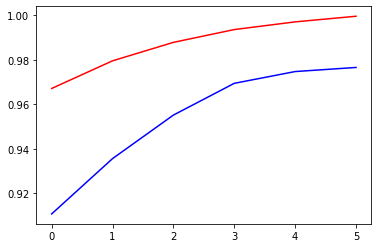

In [382]:
plt.plot(x, accs_train_l0, c='red')
plt.plot(x, accs_train_l1, c='blue')

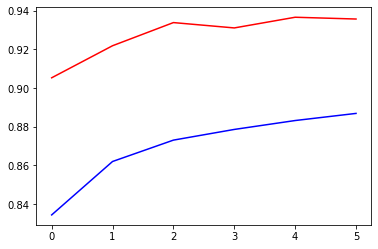

In [383]:
plt.plot(x, accs_test_l0, c='red')
plt.plot(x, accs_test_l1, c='blue')

In [404]:
f1_scores_l0 = np.array([cr0_l0['macro avg']['f1-score'], cr1_l0['macro avg']['f1-score'], cr2_l0['macro avg']['f1-score'], cr3_l0['macro avg']['f1-score'], cr4_l0['macro avg']['f1-score'], cr6_l0['macro avg']['f1-score']])
f1_scores_l1 = np.array([cr0_l1['macro avg']['f1-score'], cr1_l1['macro avg']['f1-score'], cr2_l1['macro avg']['f1-score'], cr3_l1['macro avg']['f1-score'], cr4_l1['macro avg']['f1-score'], cr6_l1['macro avg']['f1-score']])

savedata = np.column_stack((idx, f1_scores_l0, f1_scores_l1))
fname = 'results/macro_avg_f1_scores_xgb.txt'
np.savetxt(fname, savedata, header='lookback_months, f1-score_label0, f1-score_label1')


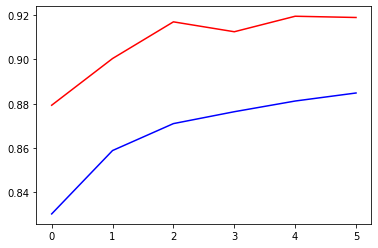

In [403]:
plt.plot(x, f1_scores_l0, c='red')
plt.plot(x, f1_scores_l1, c='blue')

In [405]:
def fit_all_new_crisis(df, cols_to_drop, target, normalize=False):
       
    # reduce dataset to X and y:
    #df_jan = df[df['EVENT_DATE_MONTH'] == '2020-01'].copy()
    df_dec = df[df['EVENT_DATE_MONTH'] == '2019-12'].copy()
    print(df_dec.size)
    # filter out Jan 2020 (no GDP data etc...)
    # filter out Dec 2019 as this will serve as prediction
    df = df[df['EVENT_DATE_MONTH'] != '2020-01']
    df = df[df['EVENT_DATE_MONTH'] != '2019-12']
    print(df.size)
    
    df = df[df[target].notna()]
        
    X = df.drop(cols_to_drop, axis=1)
    y = df[[target]]
    
    # normalize (probably not necessary for XGBoost)
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # first split main data into the training set and keep 40% of the data to
    # be split further:
    #X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42)
    # test_size is 50% so that cv and test are each 20% of original X!
    #X_test, X_cv, y_test, y_cv = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, shuffle=False)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(X_train.shape, X_test.shape)
        
    # set up classifier for MultiOutputs (y is a 2D matrix)
    #clf = MultiOutputClassifier(xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05))
    clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
    #clf.get_params()
    #clf.set_params(eval_set=[(X_cv, y_cv)], 
    #               verbose=False)
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
        
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    print("Accuracy on training data: \n", acc_train)
    print("Accuracy on test data: \n", acc_test)

    # not useful for non-continuous labels...
    #mse = mean_squared_error(y_test, pred)
    #print("Mean-squared error:", mse)
    
    X_pred = df_dec.drop(cols_to_drop, axis=1)
    print(X_pred['Battles'].size)
    #y_pred = df_dec[[target]]
    
    cr = classification_report(y_test, pred, output_dict=True)
    print(cr)
    
    # doesn't work with MultiOutputs...
    cm = confusion_matrix(y_test, pred)
    print(cm)
    
    pred_dec = clf.predict(X_pred)
    #print(pred_jan)
    print(df_dec['iso3'].size)
    print(pred_dec.size)
    
    return pred_dec, df_dec, acc_train, acc_test, cr, cm

In [406]:
cols_to_drop = ['EVENT_DATE_MONTH', 'COUNTRY', 'YEAR', 'iso3', 'battle_case', 'protest_riots_case', 'new_crisis_def']
targets = ['new_crisis_def'] #, 'protest_riots_case']
pred6_nc, df_dec6_nc, acc_train6_nc, acc_test6_nc, cr6_nc, cm6_nc = fit_all(df, cols_to_drop, targets[0])

1785
277083
(4346, 44) (1087, 44)
Accuracy on training data: 
 0.8138518177634606
Accuracy on test data: 
 0.5584176632934683
35
{'1.0': {'precision': 0.6253263707571801, 'recall': 0.793046357615894, 'f1-score': 0.6992700729927007, 'support': 604}, '3.0': {'precision': 0.3474576271186441, 'recall': 0.19902912621359223, 'f1-score': 0.25308641975308643, 'support': 206}, '4.0': {'precision': 0.42857142857142855, 'recall': 0.3140794223826715, 'f1-score': 0.3625, 'support': 277}, 'accuracy': 0.5584176632934683, 'macro avg': {'precision': 0.4671184754824176, 'recall': 0.4353849687373859, 'f1-score': 0.43828549758192903, 'support': 1087}, 'weighted avg': {'precision': 0.5225277689402605, 'recall': 0.5584176632934683, 'f1-score': 0.5288936766851214, 'support': 1087}}
[[479  47  78]
 [127  41  38]
 [160  30  87]]
35
35


In [407]:
pred6_nc

array([3., 3., 1., 1., 1., 1., 1., 1., 3., 1., 3., 1., 4., 1., 1., 1., 1.,
       1., 3., 1., 1., 1., 3., 3., 3., 1., 3., 1., 3., 1., 1., 1., 1., 1.,
       1.])

In [408]:
fname = 'results/results_xgb_classifier_Olis_labels_lookback_6m.csv'
res = pd.DataFrame()
res['iso3'] = df_dec6_nc['iso3']
res['new_crisis_def'] = pred6_nc

res.to_csv(fname)
print("Saved results to: \n", fname)

Saved results to: 
 results/results_xgb_classifier_Olis_labels_lookback_6m.csv


In [418]:
cm6_l0_norm = cm6_l0 / cm6_l0.astype(np.float).sum(axis=1)
cm6_l1_norm = cm6_l1 / cm6_l1.astype(np.float).sum(axis=1)

In [419]:

fname = 'results/confusion_mat_xgb_label0.csv'
ConfusionMatrix = pd.DataFrame(cm6_l0_norm, index = ['actual battle_case', 'actual no battle_case'], columns = ['predicted battle_case', 'predicted no battle_case'])
ConfusionMatrix.to_csv(fname, sep=',')


In [420]:
fname = 'results/confusion_mat_xgb_label1.csv'
ConfusionMatrix = pd.DataFrame(cm6_l1_norm, index = ['actual protest_riots_case', 'actual no protest_riots_case'], columns = ['predicted protest_riots_case', 'predicted no protests_riots_case'])
ConfusionMatrix.to_csv(fname, sep=',')